# 03 - Bivariate Analysis
In this notebook, we will be looking at any correlation between variables, to remove any redundancies. With what was found, including a quick variance check beforehand, we were able to remove more columns for the upcoming machine learning methods.

In [1]:
# All import insertions
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import isnull
from sklearn import preprocessing
import os    # For file paths
import re    # Regular Expressions

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Open files
df = pd.read_csv("../data/processed/data_univ.csv", low_memory=False)

In [3]:
df.dtypes.value_counts()

int64      35
object      9
float64     7
dtype: int64

In [4]:
# We will only be looking at the numerical fields, and since every string fields have nominal codes in other fields, 
# they can be removed
df = df.loc[:, (df.dtypes == np.int32) | (df.dtypes == np.float32) | (df.dtypes == np.int64) | (df.dtypes == np.float64)]

## Complete histogram
A complete histogram was created for every column to see if there's any patterns that need to be looked at before a correlation heatmap. Outside of the binary fields, the majority of the data is normally distrubited. Some of the fields, like Dir and Orientation, are not really distributed, so there might be a chance to drop these fields later on.

<Figure size 3600x2592 with 0 Axes>

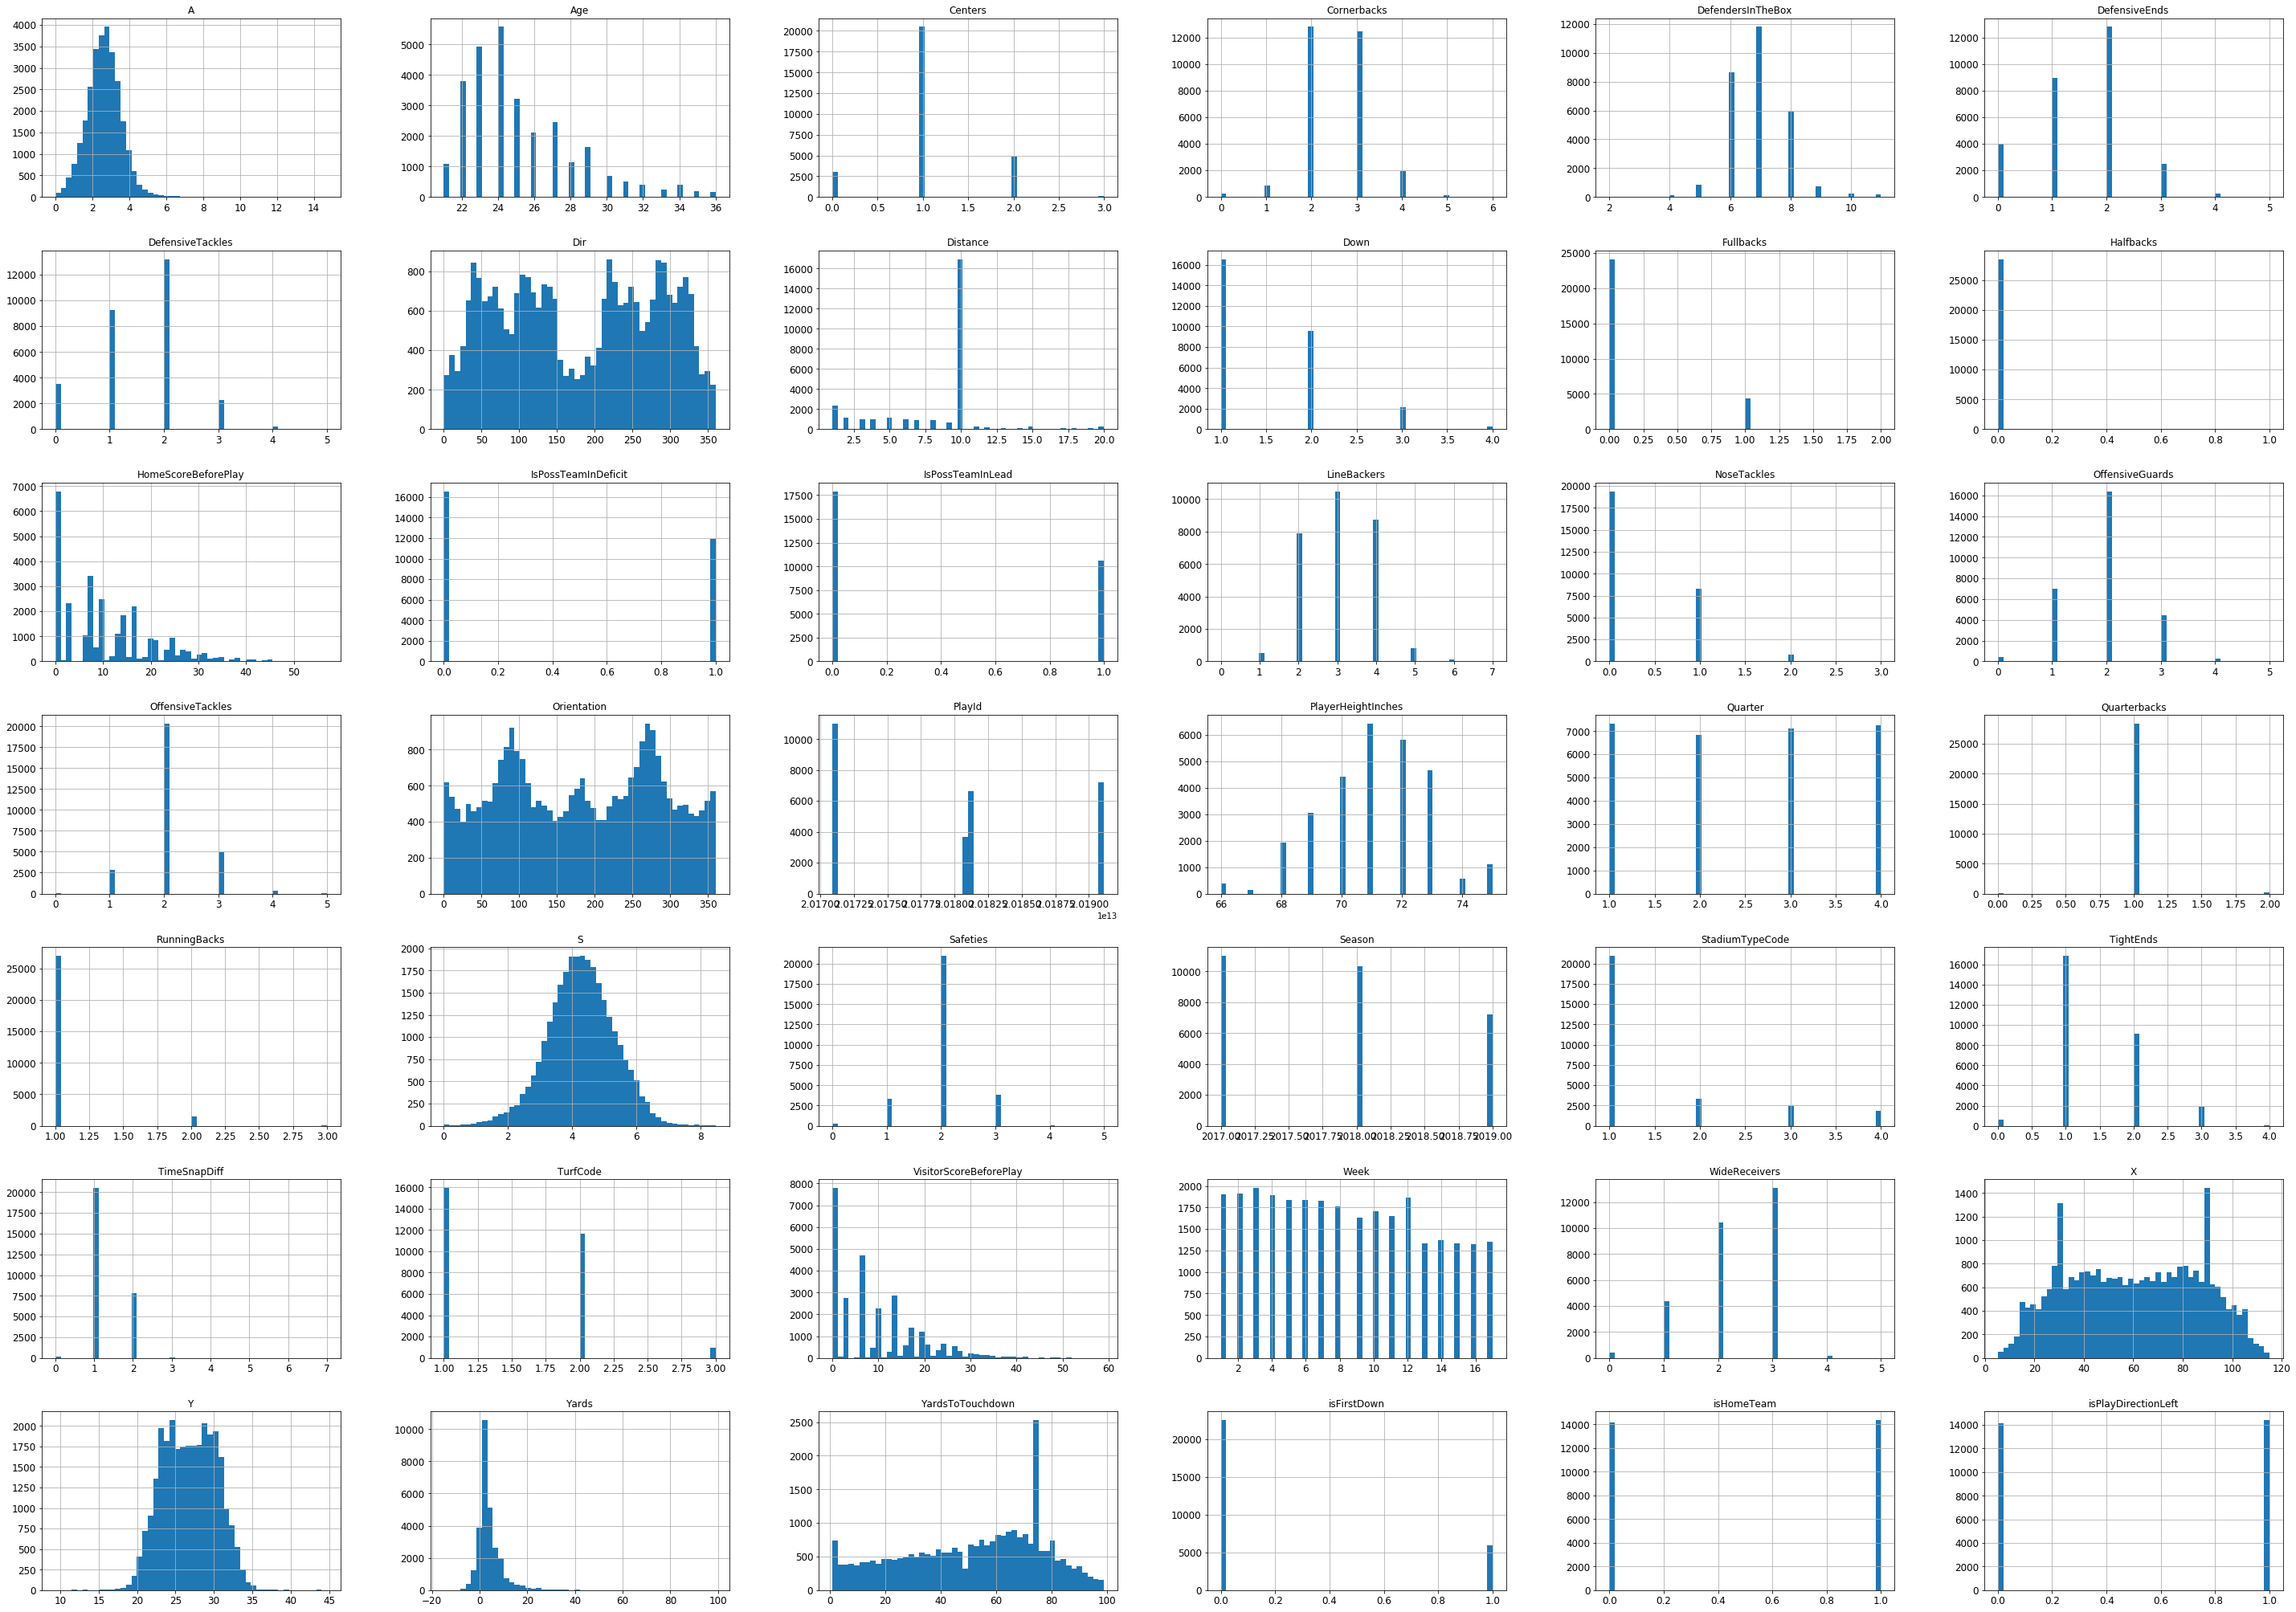

In [5]:
plt.figure(figsize=(50,36))
df.hist(figsize=(50,36), bins=50, xlabelsize=12, ylabelsize=12)
plt.savefig("../reports/figures/data_allhist.png")

## Variance Check
There is a way in Python to print out all the variances, so I can get rid of several of the fields that are obviously worth tossing. As expected many of the position fields are not worth keeping. So for example, there's very few scenarios where there's more than 1 quarterback. We can toss four position fields right off the bat. 

In [6]:
df.var().sort_values()

Halfbacks                 7.014590e-05
Quarterbacks              4.818317e-03
RunningBacks              5.152131e-02
Fullbacks                 1.324680e-01
isFirstDown               1.657367e-01
TimeSnapDiff              2.113528e-01
IsPossTeamInLead          2.335694e-01
IsPossTeamInDeficit       2.434469e-01
isPlayDirectionLeft       2.499816e-01
isHomeTeam                2.499924e-01
Centers                   2.863769e-01
NoseTackles               2.897930e-01
Safeties                  2.958499e-01
TurfCode                  3.151856e-01
OffensiveTackles          3.240585e-01
TightEnds                 4.246339e-01
Down                      4.487152e-01
OffensiveGuards           4.887744e-01
Cornerbacks               5.376614e-01
WideReceivers             6.168220e-01
Season                    6.207760e-01
DefensiveTackles          7.048649e-01
DefensiveEnds             7.611988e-01
LineBackers               8.009593e-01
StadiumTypeCode           8.012228e-01
A                        

In [7]:
df.drop(['Quarterbacks','Halfbacks','RunningBacks','Fullbacks'], axis=1, inplace=True)

## Correlation Heat map
Here, wer created several correlation tests to remove any fields that are too similar. Surprisingly, there wasn't a lot of fields that are connected. The first set of code takes the predictor variable, (isFirstDown) and looks for any high correlations with the rest of the dataset. Only one attribute met the threshold, which was the Yards. This made sense since Yards was used to calculate the "isFirstDown", so we can drop that without any issues.

The heat map was created to only show any fields that have a correlations that have a 0.5 or more correlation, high or low. 

In [8]:
#Correlation with output variable
cor = df.corr()

#Correlation with output variable
cor_target = abs(cor["isFirstDown"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Yards          0.520142
isFirstDown    1.000000
Name: isFirstDown, dtype: float64

In [9]:
# Yards is the only fields that has a high correlation with the new predictor variable, can be removed
df.drop(['Yards'], axis=1, inplace=True)

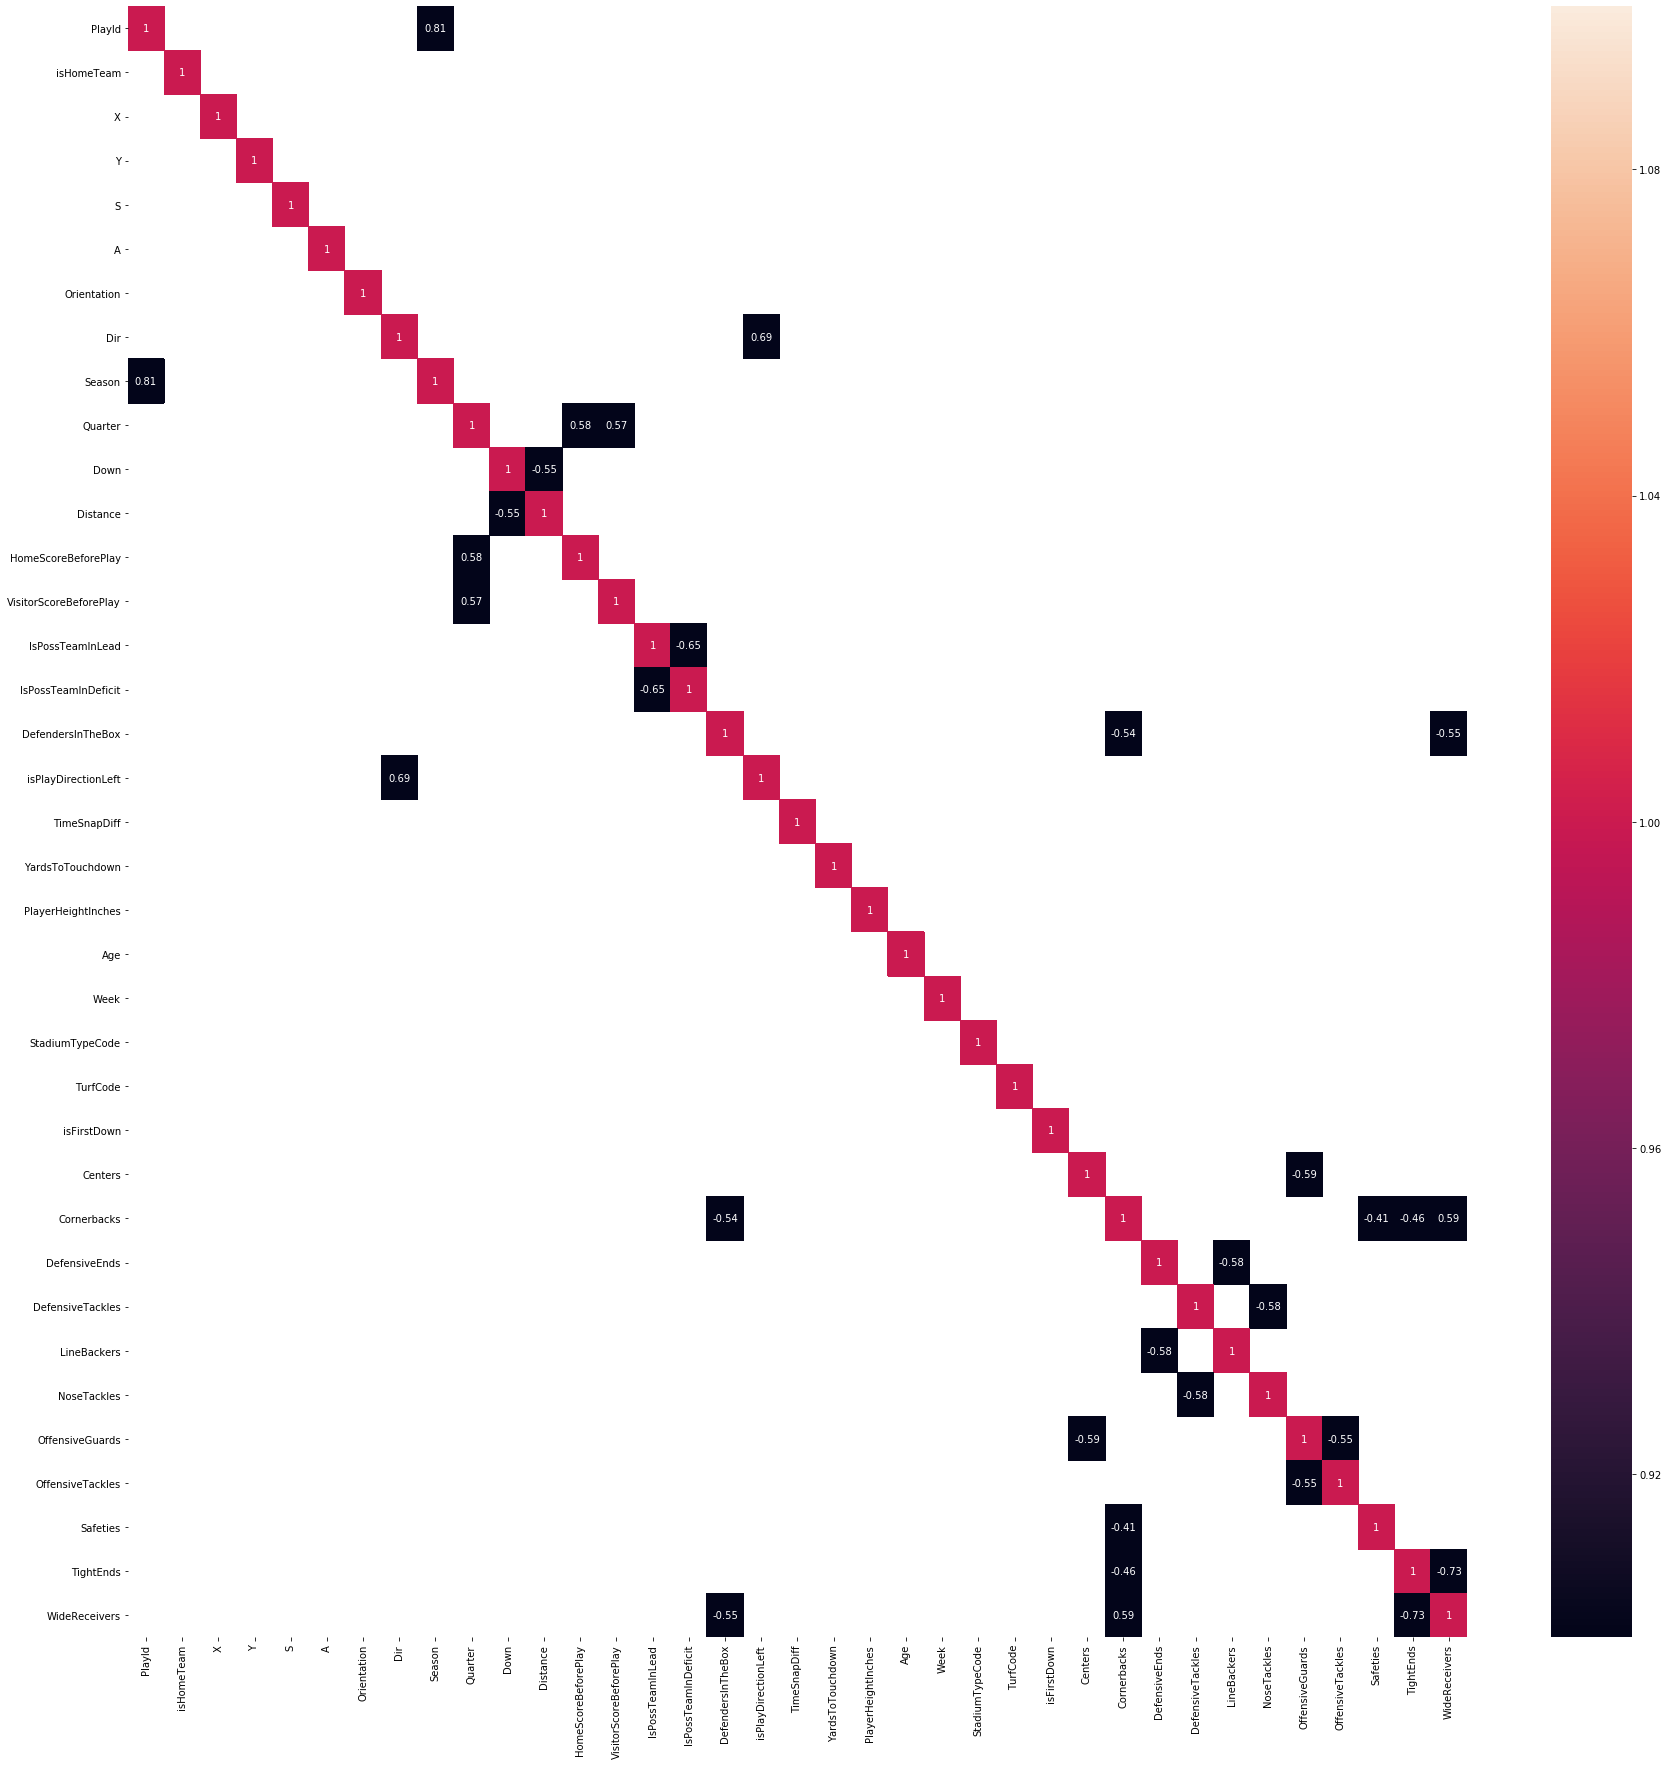

In [10]:
corrMatrix = df.corr(method = "kendall")
fig, ax = plt.subplots(figsize=(30,30)) 
# sns.heatmap(corrMatrix, annot=True)
sns.heatmap(corrMatrix[(corrMatrix>=0.5) | (corrMatrix<=-0.4)], vmax=1.0, vmin=1.0, annot=True)
plt.savefig("../reports/figures/data_corr_matrix.png")

## Checking Correlation between Lead and Deficiit
From the looks of it, the two created fields of whether the team is in the lead or deficit. This means we don't need to keep both, so dropping whether the team is in a deficit can be removed. Originally both were considered to keep because the other scenario would be a tie game, but I don't think that it would have been necessary

In [11]:
print(df[["IsPossTeamInLead","IsPossTeamInDeficit"]].corr())

                     IsPossTeamInLead  IsPossTeamInDeficit
IsPossTeamInLead             1.000000            -0.653294
IsPossTeamInDeficit         -0.653294             1.000000


In [12]:
df.drop(['IsPossTeamInDeficit'], axis=1, inplace=True)

In [13]:
df.dtypes

PlayId                      int64
isHomeTeam                  int64
X                         float64
Y                         float64
S                         float64
A                         float64
Orientation               float64
Dir                       float64
Season                      int64
Quarter                     int64
Down                        int64
Distance                    int64
HomeScoreBeforePlay         int64
VisitorScoreBeforePlay      int64
IsPossTeamInLead            int64
DefendersInTheBox           int64
isPlayDirectionLeft         int64
TimeSnapDiff              float64
YardsToTouchdown            int64
PlayerHeightInches          int64
Age                         int64
Week                        int64
StadiumTypeCode             int64
TurfCode                    int64
isFirstDown                 int64
Centers                     int64
Cornerbacks                 int64
DefensiveEnds               int64
DefensiveTackles            int64
LineBackers   

## More fields to delete
In this set of code, an easier set of code was found to find which colums can be dropped. With a threshold of 0.7 correlation, 4 can be dropped. But before we do, some more checks need to be done on fields like Wide Receivers and Tight Ends. 

In [14]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

In [15]:
to_drop

['Season', 'isPlayDirectionLeft', 'WideReceivers']

In [16]:
# Since WideRecievers was suggested more to delete, it's safer to remove that one over TightEnds
print(df[["TightEnds","WideReceivers"]].corr())

               TightEnds  WideReceivers
TightEnds       1.000000      -0.758254
WideReceivers  -0.758254       1.000000


In [17]:
df.drop(['WideReceivers'], axis=1, inplace=True)

In [18]:
# The one last group that needs to be checked are between Offensive Guards and Offensive Tackles
print(df[["OffensiveGuards","OffensiveTackles"]].corr())

                  OffensiveGuards  OffensiveTackles
OffensiveGuards          1.000000         -0.594713
OffensiveTackles        -0.594713          1.000000


In [19]:
# We can drop one, so Offensive Tackles can be dropped
df.drop(['OffensiveTackles'], axis=1, inplace=True)

## Check and save state
At the end of this process, we are down to 35 attributes. In the next notebook, several more checks will be looked at to see if we need to remove more. 

In [20]:
df.shape

(28511, 34)

In [21]:
df.to_csv("../data/processed/data_bivariate.csv")